In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import signal
from config import load_config
paths = load_config(dataset_key='all')

Paths are for dataset tagged: all


In [2]:
f = h5py.File(paths['raw_data'] / 'data_preprocessed.hdf5','r')
time = f['Time']
wavelength = f['Wavelength']
channel_1 = f['Channel1']
channel_2 = f['Channel2']
channel_3 = f['Channel3']

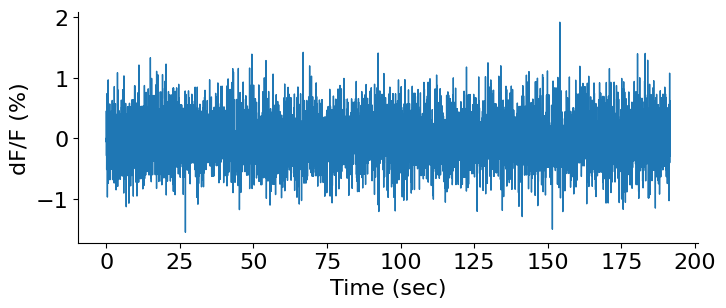

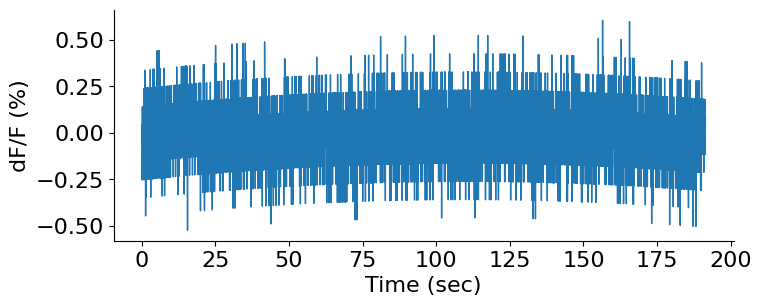

In [3]:
# Detrend the data with a second order polynomial
ch1_sig = np.zeros(channel_1.shape)
ch2_sig = np.zeros(channel_2.shape)
ch3_sig = np.zeros(channel_3.shape)
for w in wavelength:
    cff_ch1 = np.polyfit(time,channel_1[:,w-400], deg=2)
    ch1_fit = np.polyval(cff_ch1, time)
    ch1_sig[:,w-400] = channel_1[:,w-400] - ch1_fit + np.mean(channel_1[:,w-400])

    cff_ch2 = np.polyfit(time,channel_2[:,w-400], deg=2)
    ch2_fit = np.polyval(cff_ch2, time)
    ch2_sig[:,w-400] = channel_2[:,w-400] - ch2_fit + np.mean(channel_2[:,w-400])

    cff_ch3 = np.polyfit(time,channel_3[:,w-400], deg=2)
    ch3_fit = np.polyval(cff_ch3, time)
    ch3_sig[:,w-400] = channel_3[:,w-400] - ch3_fit + np.mean(channel_3[:,w-400])

ch1_sig = ndimage.uniform_filter1d(ch1_sig, size=10)
ch2_sig = ndimage.uniform_filter1d(ch2_sig, size=10)
ch3_sig = ndimage.uniform_filter1d(ch3_sig, size=10)

ch1_dff = 100*((ch1_sig-np.mean(ch1_sig, axis=0))/np.mean(ch1_sig, axis=0))
ch2_dff = 100*((ch2_sig-np.mean(ch2_sig, axis=0))/np.mean(ch2_sig, axis=0))
ch3_dff = 100*((ch3_sig-np.mean(ch3_sig, axis=0))/np.mean(ch3_sig, axis=0))

plt.rcParams.update({'font.size': 16})
f,ax = plt.subplots(figsize=(8,3))
ax.plot(time[:], ch1_dff[:,605-400], linewidth=1)
ax.set(xlabel='Time (sec)', ylabel='dF/F (%)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

f,ax = plt.subplots(figsize=(8,3))
ax.plot(time[:], ch2_dff[:,540-400], linewidth=1)
ax.set(xlabel='Time (sec)', ylabel='dF/F (%)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

# f,ax = plt.subplots(figsize=(6,2))
# ax.plot(time[:], ch1_sig[:,140], linewidth=1)
# ax.set(xlabel='Time (sec)', ylabel='Intensity moving mean')
# plt.show()



In [4]:
# Remove laser noise from signal

t = np.array(time)
freq = 1/np.diff(t)
samp_fs = np.round(np.median(freq))
noise = np.mean(ch1_dff[:,80:83], axis=1)
print(noise.shape)

from scipy.sparse.linalg import lsqr
print(np.reshape(ch1_dff[:,140],(3127,1)).shape)
result = lsqr(np.reshape(ch1_dff[:,140],(3127,1)),np.reshape(noise,(3127,1)))
print(result)
sc_noise = noise/result[0]
y = ch1_dff[:,140]-sc_noise

xlim=[300,400]
f,ax = plt.subplots(figsize=(6,2))
ax.plot(time[:], ch1_dff[:,140], linewidth=1)
ax.plot(time[:], sc_noise, linewidth=1)
ax.set(xlabel='Time (sec)', ylabel='Intensity',title='signal and scaled noise',xlim=xlim)
plt.show()

f,ax = plt.subplots(figsize=(6,2))
ax.plot(time[:], noise, linewidth=1)
ax.set(xlabel='Time (sec)', ylabel='Intensity',title='noise',xlim=xlim)
plt.show()

f,ax = plt.subplots(figsize=(6,2))
ax.plot(time[:], y, linewidth=1)
ax.set(xlabel='Time (sec)', ylabel='Intensity',title='denoised',xlim=xlim)
plt.show()

(7654,)


ValueError: cannot reshape array of size 7654 into shape (3127,1)

In [ ]:
# Highpass and lowpass filter and then remove noise

t = np.array(time)
freq = 1/np.diff(t)
samp_fs = np.round(np.median(freq))
noise = np.mean(ch1_dff[:,80:85], axis=1)
print(noise.shape)

highpass = 0.5
b,a = signal.butter(1,highpass,'highpass', fs=samp_fs)
sig_filt = signal.filtfilt(b,a,ch1_dff[:,140],axis=0)
noise_filt = signal.filtfilt(b,a,noise,axis=0)
print(noise_filt.shape)
result = lsqr(np.reshape(sig_filt,(3127,1)),np.reshape(noise_filt,(3127,1)))
print(result)
sc_noise = noise_filt*result[0]
y1 = sig_filt-sc_noise

xlim=[250,350]
f,ax = plt.subplots(figsize=(6,2))
ax.plot(time[:], sig_filt, linewidth=1)
ax.set(xlabel='Time (sec)', ylabel='Intensity',xlim=xlim)
plt.show()

f,ax = plt.subplots(figsize=(6,2))
ax.plot(time[:], noise_filt, linewidth=1)
ax.set(xlabel='Time (sec)', ylabel='Intensity',xlim=xlim)
plt.show()
f,ax = plt.subplots(figsize=(6,2))
ax.plot(time[:], sc_noise, linewidth=1)
ax.set(xlabel='Time (sec)', ylabel='Intensity',xlim=xlim)
plt.show()

f,ax = plt.subplots(figsize=(6,2))
ax.plot(time[:], y1, linewidth=1)
ax.set(xlabel='Time (sec)', ylabel='Intensity',xlim=xlim)
plt.show()

In [ ]:
lowpass = 0.5
b,a = signal.butter(1,highpass,'lowpass', fs=samp_fs)
sig_filt = signal.filtfilt(b,a,ch1_dff[:,140],axis=0)
noise_filt = signal.filtfilt(b,a,noise,axis=0)
print(noise_filt.shape)
result = lsqr(np.reshape(sig_filt,(3127,1)),np.reshape(noise_filt,(3127,1)))
print(result)
sc_noise = noise_filt/result[0]
y2 = sig_filt-sc_noise

y = y1+y2

xlim=[250,350]
f,ax = plt.subplots(figsize=(6,2))
ax.plot(time[:], sig_filt, linewidth=1)
ax.set(xlabel='Time (sec)', ylabel='Intensity',xlim=xlim)
plt.show()

# f,ax = plt.subplots(figsize=(6,2))
# ax.plot(time[:], noise_filt, linewidth=1)
# ax.set(xlabel='Time (sec)', ylabel='Intensity',xlim=xlim)
# plt.show()
f,ax = plt.subplots(figsize=(6,2))
ax.plot(time[:], sig_filt, linewidth=1)
ax.plot(time[:], sc_noise, linewidth=1)
ax.set(xlabel='Time (sec)', ylabel='Intensity',xlim=xlim)
plt.show()

f,ax = plt.subplots(figsize=(6,2))
ax.plot(time[:], y2, linewidth=1)
ax.set(xlabel='Time (sec)', ylabel='Intensity',xlim=xlim)
plt.show()

f,ax = plt.subplots(figsize=(6,2))
ax.plot(time[:], y, linewidth=1)
ax.set(xlabel='Time (sec)', ylabel='Intensity',xlim=xlim)
plt.show()

f,ax = plt.subplots(figsize=(6,2))
ax.plot(time[:], ch1_dff[:,140], linewidth=1)
ax.set(xlabel='Time (sec)', ylabel='Intensity',xlim=xlim)
plt.show()

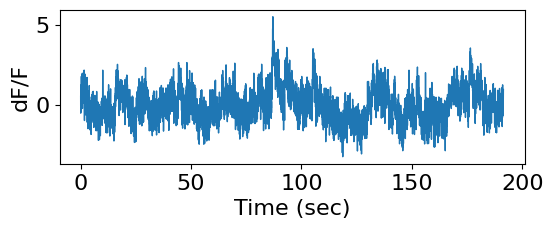

In [5]:
# Calculate dF/F for detrended data

ch1_dff = 100*((ch1_sig-np.mean(ch1_sig, axis=0))/np.mean(ch1_sig, axis=0))
ch2_dff = 100*((ch2_sig-np.mean(ch2_sig, axis=0))/np.mean(ch2_sig, axis=0))
ch3_dff = 100*((ch3_sig-np.mean(ch3_sig, axis=0))/np.mean(ch3_sig, axis=0))

f,ax = plt.subplots(figsize=(6,2))
ax.plot(time[:], ch2_dff[:,600-400], linewidth=1)
ax.set(xlabel='Time (sec)', ylabel='dF/F')
plt.show()




In [6]:
# Save data for visualizations

data_preprocessed_view = {'Time':time, 'Wavelength':wavelength, 'Channel1':channel_1, 'Channel2':channel_2, 'Channel3':channel_3, 'Ch1_dff':ch1_dff, 'Ch2_dff':ch2_dff, 'Ch3_dff':ch3_dff}
for key in data_preprocessed_view.keys():
    print(f'\n{key}')
    print(data_preprocessed_view[key])
    
hf = h5py.File(paths['raw_data'] / 'data_preprocessed_view.hdf5','a')
for key in data_preprocessed_view.keys():
    hf.create_dataset(key, data = data_preprocessed_view[key])
hf.close()


Time
<HDF5 dataset "Time": shape (7654,), type "<f8">

Wavelength
<HDF5 dataset "Wavelength": shape (300,), type "<i4">

Channel1
<HDF5 dataset "Channel1": shape (7654, 300), type "<i4">

Channel2
<HDF5 dataset "Channel2": shape (7654, 300), type "<i4">

Channel3
<HDF5 dataset "Channel3": shape (7654, 300), type "<i4">

Ch1_dff
[[-0.22885989 -0.22744667 -0.09041098 ...  0.29986435  0.40331674
   0.37791421]
 [ 0.43520143  0.40560151  0.23398345 ...  0.95338315  1.0575034
   0.95065347]
 [ 0.20242447  0.1887307   0.12839551 ... -0.19021395 -0.00549703
   0.21432045]
 ...
 [-0.17230489 -0.1608584  -0.10924838 ...  0.00557529  0.03260182
  -0.07378479]
 [ 0.30975153  0.28157533  0.14476577 ...  0.49572687  0.35971762
   0.33533316]
 [ 0.83813907  0.8026648   0.39381684 ...  0.41406884  0.44152099
   0.49900006]]

Ch2_dff
[[ 0.65889122  0.66008196  0.77423337 ... -0.14740028 -0.03220597
   0.07243161]
 [ 0.0596085   0.0607425   0.27521778 ... -0.41690591 -0.43720042
  -0.40053301]
 [ 0.45